# PhysCat Spring 2021, Homework 1
## Part 3: Monte Carlo Simulations and NumPy

v1.0 (2021 Spring): Aditya Sengupta, Aled Cuda

## Introduction

In this part of the homework, we'll apply basic Python concepts to our first scientific computing idea: Monte Carlo simulation. We'll explore three Monte Carlo simulations, with increasing complexity. We'll then see how the NumPy library can be used to speed each of them up and allow us to write cleaner code.

This part of the assignment is designed for a time budget of 3 hours.

Each section is marked with its intended time budget. If you find yourself exceeding this, feel free to say so in a Markdown cell (click on + at the top, click somewhere around the newly generated cell, hit M, and start typing): if you leave these annotations, you can still get full credit even if you weren't able to complete the section. It helps us to know if we're assigning too much or too little work!

In [1]:
import random
from math import exp
import numpy as np
from matplotlib import pyplot as plt # we'll use this, but you don't have to know it yet
from scipy import stats # as with plt
import tqdm
import time

## Monte Carlo Analysis

**Time budget**: 1.5 hours.

The $\pi$ approximation analysis and numpy speedup (questions 2 and 5) is somewhat based on EECS 126 Lab 0 (although it's a standard example used in introducing these ideas).

The first scientific computing idea we'll introduce is *Monte Carlo* analysis. This is characterized by using randomness to approximate something it might be difficult to compute otherwise. 

Suppose you want to find some quantity, but the analytic method for it doesn't exist or is difficult. The simplest version of Monte Carlo analysis says:

- design an experiment whose probability of success is directly related to the quantity
- run the experiment many times
- take the empirical success probability (the fraction of times it succeeded) and use it to find the quantity

### Monte Carlo Experiment 1: Simple Repeated Experiments
Here's a really simple Monte Carlo experiment. Suppose I know a certain test succeeds 30% of the time. If I run it 10 times, how many times will it succeed? We can answer this using the `random.random()` function, which returns a uniformly random number between 0 and 1. This uniformity means it's less than 0.3 with probability 0.3, which we can exploit:

In [2]:
random.random() # run me!

0.2699884878661608

In [7]:
success = 0
n = 10
p = 0.3
for _ in range(n):
    if random.random() < p:
        print("Success")
        success += 1
    print("Failure")
        
success

Run the cell above a few times. You'll probably get 3 (which is what you would expect just because $0.3 \times 10 = 3$) at least once, but you might see 2 or 4 as well - or maybe even other values. Based on this spread, we might ask: how often do we get the central value of 3 that we expect, and how often do we get 2 or 4? Is it likely that we get 5 or more?

This actually has an analytical solution. The number of successes follows a $Binom(10, 0.3)$ distribution. Don't worry if you haven't seen terminology like this before: the point of Monte Carlo is we don't have to know this to get useful results! The important part is in this case, you're told that the answer looks like this:

<ipython-input-8-766f2ebafef5>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(stats.binom.pmf(np.arange(n+1), n, p)) # don't worry about the numpy/stats here yet


Text(0, 0.5, 'Probability of outcome')

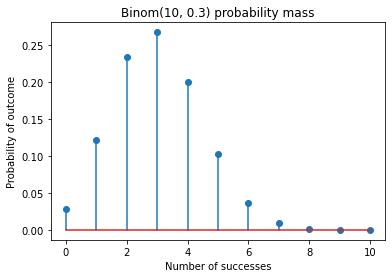

In [8]:
# run me!
plt.stem(stats.binom.pmf(np.arange(n+1), n, p)) # don't worry about the numpy/stats here yet
plt.title("Binom({0}, {1}) probability mass".format(n, p))
plt.xlabel("Number of successes")
plt.ylabel("Probability of outcome")

So we see that the central value of 3 is returned just over a quarter of the time.

Often in real problems, we don't have this analytical solution (either it's too difficult or impossible to work out, or we just don't know) and just running an experiment many times will give us a good approximation of the answer. This was actually the original thinking behind Ulam and von Neumann's development of Monte Carlo methods: they immediately put it to use to study neutron diffusion. In our case, since we do know the true answer, we can compare them!

**Question 1**: in the cell below, write code that runs the above experiment N times (where a single experiment consists of $n = 10$ trials) and assigns a list with the numbers of successes to the variable named `trials`. The cell after that will overplot your results with the probability mass function shown above, and should show good correlation if your $N$ is large enough.

In [53]:
N = 1000 # change this
trials = []
for i in tqdm.trange(N):
    # Your code here!
    success = 0
    for _ in range(n):
        if random.random() < p:
            #print("Success")
            success += 1
        #print("Failure")

    trials.append(success)

100%|██████████| 1000/1000 [00:00<00:00, 421538.09it/s]


<ipython-input-54-9892693f4241>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(stats.binom.pmf(np.arange(n+1), n, p))


Text(0, 0.5, 'Probability of outcome')

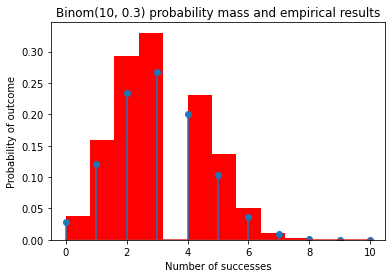

In [54]:
# run me!
plt.hist(trials, density=True, color='r')
plt.stem(stats.binom.pmf(np.arange(n+1), n, p))
plt.title("Binom({0}, {1}) probability mass and empirical results".format(n, p))
plt.xlabel("Number of successes")
plt.ylabel("Probability of outcome")

It may take a large $N$, but eventually you should see the histogram match up near-perfectly with the true probability plot.

Before we continue to more complicated Monte Carlo examples, let's talk a bit about the code structure here. 

- You probably copied some of the code from the cell that ran the experiment once to solve Question 1. This is because we didn't give you code that was reusable in the first place. In general, it's better to write code that doesn't repeat itself, for clarity and so that if there are bugs they only have to be fixed in one place. We want to build a lot of *modular* pieces that we can combine without needing a ton of "boilerplate" code. Functions (and classes/structs, but we won't use these as much) are useful for this. For a bit more on the philosophy of modular programming, look [here](https://www.cs.cornell.edu/courses/cs3110/2019sp/textbook/modules/modular_programming.html)!
- $N, n, p$ were all defined as separate variables before they were used, which allowed us to write code that isn't specific to a particular case. Instead of running the experiment with 10 and 0.3, we set $n = 10$ and $p = 0.3$ and ran it with $n$ and $p$. This means if we're curious about a different case, we only have to make one change. Go up and change $p$ to 0.4 or 0.2, and see how it affects your results!

The second point holds in general too. Whenever you write something that's dependent on some numeric parameters, see how sensitive your result is to those parameters by varying them a bit - you might discover something cool!

### Monte Carlo Experiment 2: Estimating $\pi$

One of the classic Monte Carlo examples is estimating $\pi$ by randomly selecting points in a square. This is the first visualization you'll find on the [Wikipedia page for the Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method):

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Pi_30K.gif/440px-Pi_30K.gif)

Suppose you take a circle with radius 1, and inscribe it in a square with side 2 (from -1 to 1 in the $x$ and $y$ directions). Further, only look in the first quadrant, so we have a quarter-circle within a side-1 square (from 0 to 1 in the $x$ and $y$ directions). Next, we randomly sample points within this smaller square. The quarter-circle has an area $\frac{\pi r^2}{4} = \frac{\pi}{4} \approx 0.7854$ in a square of area $s^2 = 1$, so if we randomly pick a point in the square, there's a $\frac{\pi}{4}$ chance it'll be within the circle. 

We can use this to estimate $\pi$ using the Monte Carlo method: if we pick points in the square many times and sum up the proportion that fall within the circle (in the GIF, this is $\frac{red}{red + blue}$, that fraction should approach $\frac{\pi}{4}$.

**Question 2**: write this method of estimating $\pi$. In the spirit of modularity, we've provided two function signatures (the name, inputs, and desired outputs) for you to fill in.

In [28]:
def point_in_circle():
    """
    Draws a random point (x, y) in [0, 1]^2, 
    and checks whether it lies within the circle x^2 + y^2 = 1.
    
    Returns
    -------
    in_circle : bool
        True if the point is in the circle, False otherwise.
    """
    x = random.uniform(0,1)
    y = random.uniform(0,1)
    
    if ((x**2)  + (y**2)) <= 1:
        return True
    else:
        return False

def estimate_pi(sample_points=1000):
    """
    Estimates pi using the Monte Carlo method,
    by repeatedly calling point_in_circle.
    
    Arguments
    ---------
    sample_points : int
        The number of times to repeat the experiment.
        
    Returns
    -------
    pi_est : float
        The MC estimate of pi.
    """
    total = 0
    in_circle = 0
    for _ in tqdm.trange(sample_points):
        if point_in_circle():
            in_circle+= 1
    total += 1
    pi_est = (4*in_circle/total)
    return pi_est

Now run `estimate_pi` a few times and see how far off your estimate is! How many sample points does it take to reliably get one decimal of precision? Two? Three?

In [33]:
np.pi # the true value

3.141592653589793

In [34]:
pi_est = estimate_pi(1000000)
print(pi_est)

100%|██████████| 1000000/1000000 [00:00<00:00, 1108464.10it/s]

3140736.0


In [36]:
pi_est2 = pi_est/1000000
percent_error = 100 * abs(np.pi - pi_est2) / np.pi
print("The pi estimate is {0}, which is off by {1}%".format(pi_est2, np.round(percent_error, 3)))

The pi estimate is 3.140736, which is off by 0.027%


### Monte Carlo Experiment 3: The Ising Model

Here's our first actual physics application! The [Ising model](https://en.wikipedia.org/wiki/Ising_model) is a common way of describing ferromagnetism. There's a lot of theory behind it, but for our purposes in simulating the 1D Ising model, we need to know this:

- We're simulating a row of `nparticles` particles, each of which can be spin-up (+1) or spin-down (-1). We'll make this circular, so that particle `nparticles` has particle 0 to its right.
- There's two physical effects going on: temperature wants to make the system disordered (no alignment), and magnetism wants to make the system ordered (all spins aligning). This is implemented for you in the `energy` function.

There's a total of $2^{nparticles}$ possible states for this system, which is too many to run through them all and see which one is the lowest energy - if you have, say, 100 particles (still pretty small) it'd take $2^{100} \approx 1.27 \times 10^{30}$ iterations, which is way too many. So instead we'll use Monte Carlo simulation to cleverly choose maybe 1000 of them to check, and the way in which we choose these 1000 will ensure we get close to the right answer.

What we're actually doing here is implementing a simple *Markov Chain Monte Carlo* (MCMC) method, which is a super useful technique! This will be the focus of our Probabilistic Programming section later on (where we'll probably do the Ising model in higher dimensions, i.e. with a multidimensional grid instead of a row). For our purposes, all it's important to understand is **instead of sampling points from a space and adding them up, we're sampling possible states of a system to see what's the most likely**.

The part you have to implement here should be pretty simple. Below we provide the `energy` function, which returns the energy of a state, and the `step_state` function, which takes in a list of the `nparticles` spins and returns the new state. The new state will either be the same as the old one, or will have one spin flipped. Try to read and understand roughly what it's doing!

In [37]:
import copy

nparticles = 100
J, h = 1, 2
def get_initial_state(nparticles):
    """
    Gets an initial random state.
    
    Arguments
    ---------
    nparticles : int
        The number of sites to simulate.
        
    Returns
    -------
    spins : list
        The spin states: +1 for up, -1 for down.
    """
    return [1 if random.random() < 0.5 else -1 for _ in range(nparticles)]

def energy(spins):
    """
    Gets the energy of a spin state.
    
    Arguments
    ---------
    spins : list, (nparticles)
        The spin states: +1 for up, -1 for down.
        
    Returns
    -------
    E : float
        The energy of the spin state.
    """
    E = 0.0
    for i in range(len(spins)):
        E = E - J * (spins[i] * spins[(i+1)%nparticles]) - h * spins[i]
    return E

def step_state(spins, temp=1.0):
    """
    Advances the Monte Carlo simulation by proposing a new possible state, 
    and accepting it according to the Metropolis-Hastings algorithm (not important yet.)
    
    Arguments
    ---------
    spins : list, (nparticles)
        The spin states: +1 for up, -1 for down.
    temp : float
        The temperature of the system
    """
    energy_start = energy(spins)
    new_spins = copy.copy(spins)
    random_site = random.randint(0, len(spins)-1)
    new_spins[random_site] *= -1
    energy_end = energy(new_spins)
    energy_diff = energy_end - energy_start
    if random.random() < min(1, exp(-energy_diff / temp)):
        return new_spins
    return spins

Think about why `step_state` is inefficient: we'll deal with it later when we have numpy!

A state looks like this:

In [38]:
print(get_initial_state(nparticles))

[-1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1]


**Question 3**: Suppose that for some different values of temperature, we're interested in the average spin of the stable state (this can be computed as `sum(spins) / nparticles`). For both of these states, step through some large number of times and see how the "average average spin" (i.e. average it both over all states and over all timesteps) is different between these two temperatures. Leave out the first 1000 or so steps of each run to allow the program enough time to find a good start state: this is called the "burn-in".

In [39]:
burn_in = 1000
num_steps = 10000
temps = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
avg_spins = []

for i in temps: 
    spins = []
    for j in range(num_steps):
        state = step_state(get_initial_state(nparticles), temp=i)
        if j >= burn_in:
            spins.append(np.sum(state)/nparticles)
    avg_spins.append(np.sum(spins) / nparticles)
print(avg_spins)

[0.6816000000000001, 0.6494, 0.6452000000000001, 0.5167999999999999, 0.247, 0.07240000000000003, 0.13140000000000002, -0.06700000000000003, -0.0414]


In [40]:
avg_avg_spins = []
for a in avg_spins:
    avg_avg_spins.append(np.sum(a)/(num_steps - burn_in))

Text(0, 0.5, 'Average spin')

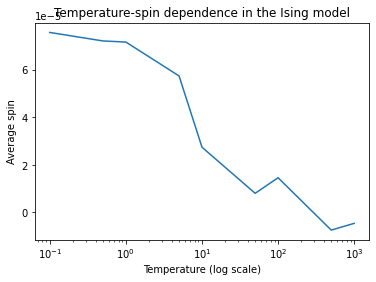

In [41]:
plt.semilogx(temps, avg_avg_spins)
plt.title("Temperature-spin dependence in the Ising model")
plt.xlabel("Temperature (log scale)")
plt.ylabel("Average spin")

Check if this result makes physical sense! Recall that we said temperature wants to make the system more disordered, which should mean closer to zero spin.

## NumPy and Efficient Code

**Time budget**: 1.5 hours.

You may have been annoyed waiting for some of the computations above to run, especially if you picked large values for the parameters (e.g. a large number of points for the $\pi$ sampler, or a large number of steps for the Ising model). You might have also noticed some inefficiencies in the code; for example, in the Ising model, `step_state` recomputes the energy of `new_spins` from scratch, even though it's almost exactly the same as `spins`. If $N = 100$, we're redoing 99 units of work.

Some of these can be fixed through clever ways of rewriting code, but for others, basic Python presents some fundamental bottlenecks. A lot of these arise from `for` loops. When we have 1000 things to do, the basic Python way of doing it means we have to do them all in order: 1, then 2, then 3, then...each one has to wait its turn. Sometimes this is necessary: each step in the Ising simulation depends on the one before it, so they all have to wait. However, in other cases like the $\pi$ sampler, no step depends on the one before it, so we should be able to run them all together.

Another annoying thing in the workflow we've used here is the lack of some simple numerical tools. We had to use a weird workaround to compute the mean of the spins, to assign items to lists and lists-of-lists, and so on - a lot of things feel sort of unnatural. Is there a better way to deal with all this?

There is! The `numpy` package (usually pronounced "num-pie") provides a wide range of numeric utilities, and generally makes working with many numbers at once a lot easier. `numpy` is usually *aliased to* `np`, meaning we usually call it `np` for convenience. We did that in the initial import way at the top, but here it is again:

In [42]:
import numpy as np

The basic structure in numpy is the *array*; if you've had a linear algebra class, this can work as a vector/matrix, but we won't deal with that for now. We can think of an array as an enhanced list of numbers.

In [43]:
a = np.array([1, 2, 3])
a[1] # works on the same rules as a list

2

However, unlike a list, you can do computations on a whole array at once! For example, I can multiply it by 2, add 3, or square the whole thing:

In [44]:
t2 = 2 * a
print(t2)
p3 = a + 3
print(p3)
sq = a ** 2
print(sq)

[2 4 6]
[4 5 6]
[1 4 9]


Almost any math function you can think of is implemented (and if there's some you can think of that aren't, they're probably in `scipy.special`):

In [45]:
np.exp(a), np.log(a), np.arctan(a)

(array([ 2.71828183,  7.3890561 , 20.08553692]),
 array([0.        , 0.69314718, 1.09861229]),
 array([0.78539816, 1.10714872, 1.24904577]))

numpy can generate whole arrays of random numbers, rather than one at a time like we've been doing with `random.random()`:

In [46]:
np.random.random(size=(3,4)) # make 3 rows with 4 elements each of random numbers

array([[0.66283558, 0.85244876, 0.61591925, 0.14784963],
       [0.33637438, 0.17084297, 0.77768685, 0.61014719],
       [0.76350411, 0.90850176, 0.37234409, 0.3339331 ]])

numpy is also way faster at doing computations than a list or list comprehension would be!

In [47]:
%timeit [random.random() for _ in range(100000)]

9.18 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%timeit np.random.random(size=(100000,))

599 µs ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


numpy has too many functions for us to run through all of them here, so you'll often be consulting the [numpy docs](https://numpy.org/doc/stable/index.html) or googling "how to do x in numpy". That's totally fine - we still do that too! This is one aspect where talking to us would definitely help.

Let's run through the three examples we did above in basic Python, and see how much faster we can make them with numpy!

### Monte Carlo Experiment 1: Simple Repeated Experiments

**Question 4**: With numpy, the quickest way to do this is to make a 2D array of size (n, N). Recall that $n = 10$ was the number of independent experiments we were adding together, and $N$ was the number of times we were running the experiment. Now, we can do the following:

- Generate all the random numbers we need at once by calling `np.random.random` with an appropriate size parameter
- Compare them all to $p$ (comparing a whole array to a number works! Also, if you add up Trues and Falses they'll get added as 1s and 0s)
- Sum up per experiment (look up `np.sum`)

Do this in the cell below and reproduce the plot from Question 1 - except this time, it should be basically instantaneous!

In [60]:
N = 1000000
numpy_trials = np.random.random(size=(n,N))

for i in numpy_trials:
    if numpy_trials <= p:
        trials_success.sum('Success')
        i += 1
    else: 
        trials_fail.sum('Failure')
    

plt.hist(numpy_trials, density=True, color='r')
plt.stem(stats.binom.pmf(np.arange(n+1), n, p))
plt.title("Binom({0}, {1}) probability mass and empirical results".format(n, p))
plt.xlabel("Number of successes")
plt.ylabel("Probability of outcome")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Note that `np.sum` (like many other functions) takes in an "axis" parameter. This indicates whether it should sum along rows, along columns, or both. The outer axis (the columns) is number 0, and the inner one (the rows) is number 1. If you're ever not sure about this (we frequently are!) just remember it works in the same order as a regular list-of-lists would. The first one lets you pick which smaller list (which row) you look into, so it's the choice of column. The second one lets you pick within the row.

Quick example usage:

In [56]:
b = np.arange(9).reshape((3,3))
b # just to get a starting array

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [57]:
np.sum(b, axis=0) # sums along columns

array([ 9, 12, 15])

In [58]:
np.sum(b, axis=1) # sums along rows

array([ 3, 12, 21])

In [59]:
np.sum(b) # does both

36

### Monte Carlo Experiment 2: Estimating $\pi$

**Question 5**: reproduce the $\pi$ estimator from Question 2 using numpy. We'll give you less guidance for this one, but keep in mind you can square an entire array at once (and you may still want to use `np.sum`). 

Then, run the cell below that to see the speedup over `estimate_pi`! It should get better by at least a factor of 10.

In [83]:
def estimate_pi_numpy(sample_points=100):
    array = np.random.random(size=(2, sample_points))
    for [i][j] in array:
        if [i] > 1: 
            array.remove([i])
        elif [j] > 1:
            array.remove([j])
    print(array)
        
    

In [84]:
estimate_pi_numpy(10)

TypeError: list indices must be integers or slices, not numpy.float64

In [76]:
npoints_test = 10000000
s1 = time.time()
print("pi estimate without numpy: {}".format(estimate_pi(npoints_test)))
s2 = time.time()
print("pi estimate with numpy   : {}".format(estimate_pi_numpy(npoints_test)))
s3 = time.time()
ratio = (s2 - s1) / (s3 - s2)
print("numpy was {} times faster".format(ratio))

100%|██████████| 10000000/10000000 [00:08<00:00, 1206808.65it/s]


pi estimate without numpy: 31412896.0
pi estimate with numpy   : 8e-06
numpy was 0.7869232333365884 times faster


### Monte Carlo Experiment 3: The Ising Model

There's a decent amount of the Ising model that can be rewritten! We'll focus on two parts. (If you're running short on time at this point, we'd recommend skipping to Question 7 as this optimization isn't as critical.)

**Question 6**: below is `energy` and `step_state` again. There's not that much that can be optimized with numpy actually, but we can avoid all the redundant work in computing the energy twice that we described above. Rewrite `step_state_better` so that it doesn't call `energy` on a length-`nparticles` list more than once. (You don't need to change `energy`, it's just there for convenience). You can also change the inputs or outputs of `step_state`.

*Extra challenge*: write a version of `step_state_better` that doesn't call `energy` at all! (Without just computing the energy of the whole state inside `step_state_better`.)

In [ ]:
nparticles = 100
J, h = 1, 2
def get_initial_state_np(nparticles):
    """
    Gets an initial random state.
    
    Arguments
    ---------
    nparticles : int
        The number of sites to simulate.
        
    Returns
    -------
    spins : list
        The spin states: +1 for up, -1 for down.
    """
    return np.random.choice([-1, 1], (nparticles,)) # also numpy-improved!

def energy(spins):
    """
    Gets the energy of a spin state.
    
    Arguments
    ---------
    spins : list, (nparticles)
        The spin states: +1 for up, -1 for down.
        
    Returns
    -------
    E : float
        The energy of the spin state.
    """
    E = 0.0
    for i in range(len(spins)):
        E = E - J * (spins[i] * spins[(i+1)%nparticles]) - h * spins[i]
    return E

def step_state_better(spins, temp=1.0):
    """
    Advances the Monte Carlo simulation by proposing a new possible state, 
    and accepting it according to the Metropolis-Hastings algorithm (not important yet.)
    
    Arguments
    ---------
    spins : list, (nparticles)
        The spin states: +1 for up, -1 for down.
    current_energy : float
        The energy of the current state.
    temp : float
        The temperature of the system
    """
    # Currently, this is just step_state from above.
    # Your (rewritten) code here!
    
    energy_start = energy(spins)
    new_spins = copy.copy(spins)
    random_site = random.randint(0, len(spins)-1)
    new_spins[random_site] *= -1
    energy_end = energy(new_spins)
    energy_diff = energy_end - energy_start
    if random.random() < min(1, exp(-energy_diff / temp)):
        return new_spins
    return spins

**Question 7**: rerun the analysis for average spin using numpy. The speedup won't be as drastic here as with the $\pi$ simulation, but the syntax should look a lot nicer. (There are actually ways to make this much faster, and we'll learn about those later!)

Possibly relevant functions: `np.empty`, `np.mean`. Note that `np.mean` takes an axis argument like `np.sum` does.

In [ ]:
burn_in = ...
num_steps = ...
temps = np.array([0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000])
avg_spins_np = ...

# Your code here!

In [ ]:
avg_avg_spins_np = ... # Your code here!

In [ ]:
plt.semilogx(temps, avg_avg_spins_np)
plt.title("Temperature-spin dependence in the Ising model")
plt.xlabel("Temperature (log scale)")
plt.ylabel("Average spin")

Congratulations, you're done! Zip this file together with `physcat_sp21_hw1_p1.ipynb` and submit it to Gradescope.